In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import remaining libraries  

In [3]:
# Custom tools
from mytools import *

# General tools
import re
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# Tuning and model selection
from sklearn.model_selection import GridSearchCV, cross_val_score

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Successfully imported all libraries!")


Successfully imported all libraries!


## Load datasets  

In [4]:
traindf = load_csv("train")
traindf.shape

(162758, 5)

In [5]:
testdf = load_csv("test")
testdf.shape

(55315, 4)

## Getting data ready for training and evaluating models  

`Handle missing data. Current strategy is to fill in some custom text.`  
`Separate features and labels from traindf`  
`Split training data into training and testing parts`

In [6]:
traindf.shape

(162758, 5)

In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [8]:
traindf.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

### Fill empty reviewText with custom text  

In [9]:
traindf["reviewText"].fillna(" ", inplace=True)
traindf.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

### Separate features and labels  

In [10]:
train_features = traindf["reviewText"]
train_labels = traindf.iloc[:, -1]
train_features.shape, train_labels.shape

((162758,), (162758,))

### Split traindf into training and testing parts  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((122068,), (40690,), (122068,), (40690,))

### Needs further exploration  

`stratify based on reviewer type?`  
`play with test size`  

## Model evaluation plan and code  

# Data preprocessing  

## Define stop words  

In [12]:
stop_words = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
type(stop_words), len(stop_words)

(list, 1160)

## Feature extraction  

## Model building workflow  

`Make pipeline for preprocesing and model training and predictions`  


## Preprocessor(s)  

In [12]:
tvec = TfidfVectorizer()
tvec_sw = TfidfVectorizer(stop_words=stop_words)

## Logistic Regression with TfidVectorizer for preprocessing  

In [13]:
logreg = LogisticRegression(max_iter=100000)
logreg

LogisticRegression(max_iter=100000)

In [14]:
tvec = TfidfVectorizer()
cvec = CountVectorizer()        # Note that TfidfVectorizer and CountVectorizer+TfidsTransformer do the same function
tvec, cvec

(TfidfVectorizer(), CountVectorizer())

In [15]:
# logreg_pipe = preprocess_n_train(X_train, y_train, tvec, logreg)
# logreg_pipe

In [16]:
# y_pred_logreg = predict_n_evaluate(logreg_pipe, X_test, y_test)
# y_pred_logreg

In [13]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

In [18]:
pipe = Pipeline(steps=[("preprocessor", tvec), ("model", logreg)])
pipe

Pipeline(steps=[('preprocessor', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=100000))])

In [19]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1_micro")
display_scores(scores)

Scores: [0.79270091 0.79560908 0.79831244 0.79236472 0.79670667]
Mean: 0.7951387652281181
Standard deviation: 0.0022973989377842036


### With n_gram and min/max_df defined in TfidfVectorizer  

In [20]:
logreg_2 = LogisticRegression(max_iter=100000, C=2)

In [21]:
tvec_ngram_2_df = TfidfVectorizer(ngram_range=(1,2), stop_words=None, min_df=0.0001, max_df=0.50)
tvec_ngram_2_df

TfidfVectorizer(max_df=0.5, min_df=0.0001, ngram_range=(1, 2))

In [22]:
pipe_2 = Pipeline(steps=[("preprocessor", tvec_ngram_2_df), ("model", logreg_2)])
pipe_2

Pipeline(steps=[('preprocessor',
                 TfidfVectorizer(max_df=0.5, min_df=0.0001,
                                 ngram_range=(1, 2))),
                ('model', LogisticRegression(C=2, max_iter=100000))])

In [23]:
scores_2 = cross_val_score(pipe_2, X_train, y_train, cv=5, scoring="f1_micro")
display_scores(scores_2)

Scores: [0.81023183 0.80883919 0.81101008 0.80707    0.80833982]
Mean: 0.8090981847286199
Standard deviation: 0.0013925663353970697


### GridSearchCV  

In [24]:
pipe

Pipeline(steps=[('preprocessor', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=100000))])

In [25]:
param_grid = {
    "preprocessor__ngram_range": [(1,1), (1,2)],
    # "preprocessor__stop_words": [None, "english"],
    "preprocessor__max_features": [1000, 5000, 10000, 30000, None],
    "model__C": [0.1, 1, 10, 100]
}
param_grid

{'preprocessor__ngram_range': [(1, 1), (1, 2)],
 'preprocessor__max_features': [1000, 5000, 10000, 30000, None],
 'model__C': [0.1, 1, 10, 100]}

In [26]:
search = GridSearchCV(pipe, param_grid, cv=5, scoring="f1_micro", n_jobs=-1)
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', TfidfVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'preprocessor__max_features': [1000, 5000, 10000,
                                                        30000, None],
                         'preprocessor__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_micro')

In [27]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', TfidfVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'preprocessor__max_features': [1000, 5000, 10000,
                                                        30000, None],
                         'preprocessor__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_micro')

In [28]:
print(f"Best score: {search.best_score_}")

Best score: 0.8152341104465025


In [29]:
print(f"Best params: {search.best_params_}")

Best params: {'model__C': 10, 'preprocessor__max_features': None, 'preprocessor__ngram_range': (1, 2)}


### Use the best params to evaluate on the test set  

In [52]:
predict_n_evaluate(search, X_test, y_test)

y_pred shape: (40690,)
Summary of predictions: (array(['NEGATIVE', 'POSITIVE'], dtype=object), array([10960, 29730], dtype=int64))
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.63      0.69     13430
    POSITIVE       0.83      0.91      0.87     27260

    accuracy                           0.82     40690
   macro avg       0.80      0.77      0.78     40690
weighted avg       0.81      0.82      0.81     40690

[[ 8454  4976]
 [ 2506 24754]]


array(['POSITIVE', 'NEGATIVE', 'NEGATIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype=object)

### Visualize predicted probabilities  

In [56]:
preds = search.predict(X_test)
preds

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype=object)

In [53]:
proba = search.predict_proba(X_test)
proba

array([[0.38787799, 0.61212201],
       [0.89808939, 0.10191061],
       [0.92227897, 0.07772103],
       ...,
       [0.00365036, 0.99634964],
       [0.08098421, 0.91901579],
       [0.01499559, 0.98500441]])

In [57]:
pos_proba = proba[:,1]
pos_proba

array([0.61212201, 0.10191061, 0.07772103, ..., 0.99634964, 0.91901579,
       0.98500441])

<AxesSubplot:ylabel='Count'>

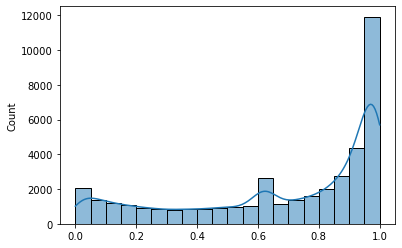

In [62]:
sns.histplot(pos_proba, bins=20, kde=True)

In [60]:
neg_proba = proba[:,0]
neg_proba

array([0.38787799, 0.89808939, 0.92227897, ..., 0.00365036, 0.08098421,
       0.01499559])

<AxesSubplot:ylabel='Count'>

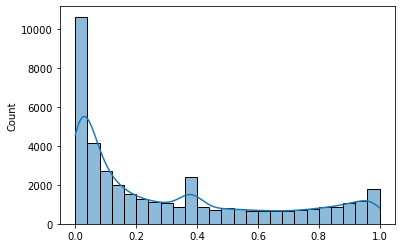

In [61]:
sns.histplot(neg_proba, bins=25, kde=True)

### Play with the probability threshold cut off  

In [85]:
y_pred_mod = np.where(pos_proba > 0.6, "POSITIVE", "NEGATIVE")
y_pred_mod

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype='<U8')

In [86]:
evaluate(y_test, y_pred_mod)

              precision    recall  f1-score   support

    NEGATIVE       0.73      0.70      0.71     13430
    POSITIVE       0.86      0.87      0.86     27260

    accuracy                           0.81     40690
   macro avg       0.79      0.79      0.79     40690
weighted avg       0.81      0.81      0.81     40690

[[ 9414  4016]
 [ 3527 23733]]


### Improving the GridSearchCV results from above  
`Tune min_df and max_df in TfidfVectorizer`  

In [90]:
logreg_cv1 = LogisticRegression(max_iter=100000, C=10)
tvec_cv1 = TfidfVectorizer(ngram_range=(1,2), max_features=None)

In [91]:
pipe_cv2 = Pipeline(steps=[("preprocessor", tvec_cv1), ("model", logreg_cv1)])
pipe_cv2

Pipeline(steps=[('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),
                ('model', LogisticRegression(C=10, max_iter=100000))])

In [93]:
param_grid_cv2 = {"preprocessor__min_df": [1, 2, 5, 0.0001],
                    "preprocessor__max_df": [0.3, 0.5, 0.7]}

In [94]:
search_cv2 = GridSearchCV(pipe_cv2, param_grid_cv2, cv=5, scoring="f1_micro", n_jobs=-1)
search_cv2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('model',
                                        LogisticRegression(C=10,
                                                           max_iter=100000))]),
             n_jobs=-1,
             param_grid={'preprocessor__max_df': [0.3, 0.5, 0.7],
                         'preprocessor__min_df': [1, 2, 5, 0.0001]},
             scoring='f1_micro')

In [95]:
search_cv2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('model',
                                        LogisticRegression(C=10,
                                                           max_iter=100000))]),
             n_jobs=-1,
             param_grid={'preprocessor__max_df': [0.3, 0.5, 0.7],
                         'preprocessor__min_df': [1, 2, 5, 0.0001]},
             scoring='f1_micro')

In [96]:
search_cv2.best_score_

0.8152341104465025

In [97]:
search_cv2.best_params_

{'preprocessor__max_df': 0.7, 'preprocessor__min_df': 1}

In [120]:
predict_n_evaluate(search_cv2, X_test, y_test)

y_pred shape: (40690,)
Summary of predictions: (array(['NEGATIVE', 'POSITIVE'], dtype=object), array([10960, 29730], dtype=int64))
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.63      0.69     13430
    POSITIVE       0.83      0.91      0.87     27260

    accuracy                           0.82     40690
   macro avg       0.80      0.77      0.78     40690
weighted avg       0.81      0.82      0.81     40690

[[ 8454  4976]
 [ 2506 24754]]


array(['POSITIVE', 'NEGATIVE', 'NEGATIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype=object)

### Playing with fewer max_features  

In [128]:
# tvec_min = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=1, max_df=0.7)
vocab = get_tfidf_vocab(traindf, ngram_range=(1,2), max_features=10000, min_df=1, max_df=0.7)
tvec_min = TfidfVectorizer(ngram_range=(1,2), vocabulary=vocab)


y_pred shape: (40690,)
Summary of predictions: (array(['NEGATIVE', 'POSITIVE'], dtype=object), array([11360, 29330], dtype=int64))
              precision    recall  f1-score   support

    NEGATIVE       0.73      0.61      0.67     13430
    POSITIVE       0.82      0.89      0.85     27260

    accuracy                           0.80     40690
   macro avg       0.78      0.75      0.76     40690
weighted avg       0.79      0.80      0.79     40690

[[ 8258  5172]
 [ 3102 24158]]


array(['NEGATIVE', 'NEGATIVE', 'NEGATIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype=object)

In [ ]:
log_reg_min = LogisticRegression(max_iter=100000, C=10)


pipe_min = Pipeline(steps=[("preprocessor", tvec_min), ("model", log_reg_min)])
pipe_min.fit(X_train, y_train)

predict_n_evaluate(pipe_min, X_test, y_test)

### Brief encounter with ensemble  

`RandomForestClassifier`  

In [129]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc

RandomForestClassifier()

In [130]:
pipe_rfc = Pipeline(steps=[("preprocessor", tvec_min), ("model", rfc)])
pipe_rfc.fit(X_train, y_train)
predict_n_evaluate(pipe_rfc, X_test, y_test)

y_pred shape: (40690,)
Summary of predictions: (array(['NEGATIVE', 'POSITIVE'], dtype=object), array([ 6152, 34538], dtype=int64))
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.35      0.48     13430
    POSITIVE       0.75      0.95      0.84     27260

    accuracy                           0.75     40690
   macro avg       0.76      0.65      0.66     40690
weighted avg       0.75      0.75      0.72     40690

[[ 4711  8719]
 [ 1441 25819]]


array(['POSITIVE', 'POSITIVE', 'NEGATIVE', ..., 'POSITIVE', 'POSITIVE',
       'POSITIVE'], dtype=object)

`AdaBoost with Logistic regression`  

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# logreg_adbc = LogisticRegression(max_iter=10000, C=10)
# mnb_adbc = MultinomialNB()
adbc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
adbc

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

In [13]:
tvec_min = TfidfVectorizer(ngram_range=(1,2), max_features=20000, min_df=1, max_df=0.7)

# vocab = get_tfidf_vocab(traindf, ngram_range=(1,2), max_features=10000, min_df=1, max_df=0.7)
# tvec_min = TfidfVectorizer(ngram_range=(1,2), vocabulary=vocab)

In [14]:
# cvec_min = CountVectorizer(ngram_range=(1,2), max_features=10000)

# from mytools import get_countvec_vocab
# vocab = get_countvec_vocab(traindf, ngram_range=(1,2), max_features=50000, min_df=1, max_df=0.7)
# cvec_min = CountVectorizer(ngram_range=(1,2), vocabulary=vocab)

In [15]:
pipe_adbc = Pipeline(steps=[("preprocessor", tvec_min), ("model", adbc)])
pipe_adbc.fit(X_train, y_train)
predict_n_evaluate(pipe_adbc, X_test, y_test)

y_pred shape: (40690,)
Summary of predictions: (array(['NEGATIVE', 'POSITIVE'], dtype=object), array([13886, 26804], dtype=int64))
              precision    recall  f1-score   support

    NEGATIVE       0.48      0.50      0.49     13430
    POSITIVE       0.75      0.74      0.74     27260

    accuracy                           0.66     40690
   macro avg       0.62      0.62      0.62     40690
weighted avg       0.66      0.66      0.66     40690

[[ 6731  6699]
 [ 7155 20105]]

### Return to NB  

In [ ]:
# tvec_min = TfidfVectorizer(ngram_range=(1,2), max_features=40000, min_df=1, max_df=0.7)

# vocab = get_tfidf_vocab(traindf, ngram_range=(1,2), max_features=60000, min_df=1, max_df=0.7)
# tvec_min = TfidfVectorizer(ngram_range=(1,2), vocabulary=vocab)

In [ ]:
# cvec_min = CountVectorizer(ngram_range=(1,2), max_features=50000)

# from mytools import get_countvec_vocab
# vocab = get_countvec_vocab(traindf, ngram_range=(1,2), max_features=50000, min_df=1, max_df=0.7)
# cvec_min = CountVectorizer(ngram_range=(1,2), vocabulary=vocab)

In [ ]:
# mnb1 = MultinomialNB()
# pipe_mnb1 = Pipeline(steps=[("preprocessor", cvec_min), ("model", mnb1)])
# pipe_mnb1.fit(X_train, y_train)
# predict_n_evaluate(pipe_mnb1, X_test, y_test)

### Logistic Regression with stop words  

In [ ]:
# tvec_sw = TfidfVectorizer(stop_words=stop_words)

In [ ]:
# logreg_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, logreg)
# logreg_sw_pipe

In [ ]:
# y_pred_logreg_sw = predict_n_evaluate(logreg_sw_pipe, X_test, y_test)
# y_pred_logreg_sw

### Logistic regression with different ngram ranges  

#### ngram range (1,2)  

In [ ]:
# tvec_ngram_2 = TfidfVectorizer(ngram_range=(1,2))

In [ ]:
# logreg_ng2_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2, logreg)
# logreg_ng2_pipe

In [ ]:
# y_pred_logreg_ng2 = predict_n_evaluate(logreg_ng2_pipe, X_test, y_test)
# y_pred_logreg_ng2

### Logistic regression with C=2, ngram range (1,2), stop words as None and min_df, max_df adjusted     

In [ ]:
# logreg = LogisticRegression(max_iter=100000, C=2)

In [ ]:
# tvec_ngram_2_sw_df = TfidfVectorizer(ngram_range=(1,2), stop_words=None, min_df=0.0001, max_df=0.50)
# tvec_ngram_2_sw_df

In [ ]:
# logreg_ng2_sw_df_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2_sw_df, logreg)
# logreg_ng2_sw_df_pipe

In [ ]:
# y_pred_logreg_ng2_sw_df = predict_n_evaluate(logreg_ng2_sw_df_pipe, X_test, y_test)
# y_pred_logreg_ng2_sw_df

## SVM model  

In [ ]:
# svm = LinearSVC()
# svm

In [ ]:
# svm_pipe = preprocess_n_train(X_train, y_train, tvec, svm)
# svm_pipe

In [ ]:
# y_pred_svm = predict_n_evaluate(svm_pipe, X_test, y_test)
# y_pred_svm

### SVM model with stop words  

In [ ]:
# svm_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, svm)
# svm_sw_pipe

In [ ]:
# y_pred_svm_sw = predict_n_evaluate(svm_sw_pipe, X_test, y_test)
# y_pred_svm_sw

## Naive Bayes model  

### MultinomialNB  

In [ ]:
# mnb = MultinomialNB()
# mnb

In [ ]:
# mnb_pipe = preprocess_n_train(X_train, y_train, tvec, mnb)
# mnb_pipe

In [ ]:
# y_pred_mnb = predict_n_evaluate(mnb_pipe, X_test, y_test)
# y_pred_mnb

### GaussianNB  

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [ ]:
# gnb = GaussianNB()
# gnb

In [ ]:
# gnb_pipe = preprocess_n_train(X_train, y_train, tvec, gnb)
# gnb_pipe

## Submitting predictions to Kaggle competition  

In [ ]:
def submit(selected_model=logreg, selected_preprocessor=tvec):
    
    # Retrain on the whole train.csv file  
    traindf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
    X_train = traindf["reviewText"]
    X_train.fillna("empty", inplace=True)
    y_train = traindf["sentiment"]
    pipe = preprocess_n_train(X_train, y_train, selected_preprocessor, selected_model)
    
    # Predict on test.csv file
    testdf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
    X_test = testdf["reviewText"]
    X_test.fillna("empty", inplace=True)
    
    y_pred = pipe.predict(X_test)
    
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["sentiment"]
    pred_df.index.name = "id"
    pred_df.to_csv("submission.csv")
    
    return "Successfully created the submission file!!!"

NameError: name 'logreg' is not defined

In [ ]:
# submit(logreg, tvec_ngram_2_sw_df)